## Hybrid Images

<p style='direction:rtl; text-align: right'>
برای ساخت تصویر هیبرید، همانطور که در صورت تمرین گفته شده،ابتدا دو تصویر انتخاب شده که
تصاویر صورت انسان هستند را با استفاده نقاط متناظر صورت، رجیستر میکنیم. سپس هر یک را به حوزه فرکانس می‌بریم
و فیلترهای بالاگذر و پایین‌گذر روی آن‌ها اعمال می‌کنیم و در نهایت آن‌ها را با هم ترکیب کرده و به حوزه مکان بر می‌گردانیم.
</p>

<p style='direction:rtl; text-align: right'>
ابتدا ایمپورت‌های لازم را انجام میدهیم و عکس‌‌ها را لود میکنیم.
</p>

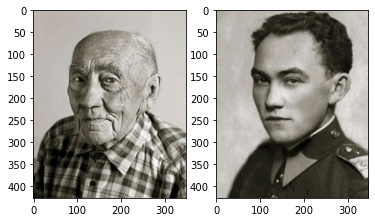

In [1]:
import cv2 as cv
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

near = cv.imread('./data/q4_01_near.jpg')
far = cv.imread('./data/q4_02_far.jpg')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv.cvtColor(near, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(far, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
برای رجیستر کردن دو صورت از تبدیل آفینی استفاده میکنیم. تبدیل آفینی به حداقل سه نقطه متناظر احتیاج دارد. این سه نقطه را مردمک دو چشم و زیر بینی انتخاب می‌کنیم. این تبدیل را صرفا روی یکی از عکس‌ها اعمال میکنیم.
</p>

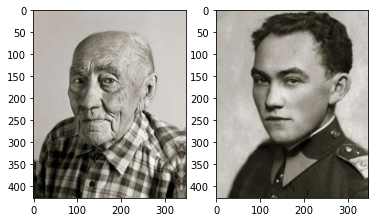

In [2]:
# x,y coords
# near
cue_points_near = np.array([
    (179, 160),  # right eye
    (108, 157),  # left eye
    (131, 223),  # nose bottom
    # (134, 250)  # mid lip
])
# far
cue_points_far = np.array([
    (176, 161),
    (108, 160),
    (130, 225),
    # (133, 250)
])

t_mat, _ = cv.estimateAffine2D(cue_points_near, cue_points_far)
near = cv.warpAffine(near, t_mat, far.shape[:2][::-1], flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv.cvtColor(near, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(far, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
از دو تصویر به دست آمده تبدیل فوریه می‌گیریم. برای نمایش آن‌ها، صرفا بزرگی ضرایب فوریه را به دست می‌آوریم. از آنجایی که اختلاف بزرگی ضرایب فوریه چندین مرتبه بزرگی‌ست و نمایش آن‌ها در عکس ممکن نیست، لگاریتم آن ها‌ را نمایش می‌دهیم. تابع کمکی calc_log_normalized_mag را برای این منظور تعریف کرده‌ایم.
</p>

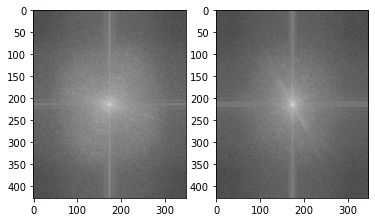

In [3]:
def calc_log_normalized_mag(src):
    src = np.log(np.abs(src) + 0.00000001)
    src -= src.min(initial=0)
    src /= src.max(initial=1)
    return (src * 255).astype(np.uint8)


def calc_dft(src):
    dft_full = list()
    for i in range(3):
        dft = np.fft.fft2(src[:, :, i])
        dft = np.fft.fftshift(dft)
        dft_full.append(dft)
    return np.stack(dft_full, axis=2)


near_dft = calc_dft(near)
far_dft = calc_dft(far)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(calc_log_normalized_mag(near_dft), cmap='gray')
axs[1].imshow(calc_log_normalized_mag(far_dft), cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
فیلتر های گوسی با انحراف معیار ۱۲ و ۳۴ برای فیلتر های پایین‌گذر و بالا گذر تولید میکنیم.
</p>

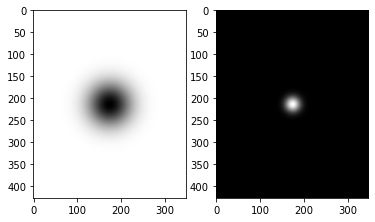

In [4]:
def binormal_pdf(pos, sigma, mean):
    pos = np.array(pos) - np.array(mean)
    return math.exp(-((pos * pos).sum()) / sigma ** 2 / 2) / (2 * math.pi * sigma ** 2)


def gaussian_filter_shfited(dims, sigma):
    res = np.zeros(dims)
    mean = np.array(dims) / 2
    for loc in np.ndindex(dims):
        res[loc] = binormal_pdf(loc, sigma, mean)
    return res / res.max()


lowpass_sigma = 12
highpass_sigma = 34

lowpass_filter = gaussian_filter_shfited(far.shape[:2], lowpass_sigma)
highpass_filter = 1 - gaussian_filter_shfited(near.shape[:2], highpass_sigma)

fig, axs = plt.subplots(1, 2)
axs[0].imshow((highpass_filter * 255).astype(np.uint8), cmap='gray')
axs[1].imshow((lowpass_filter * 255).astype(np.uint8), cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
در اینجا فیلتر‌های cutoff ایده‌ال تولید میکنیم و در فیلتر های قبلی ضرب میکنیم.
</p>

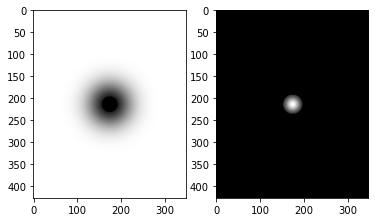

In [5]:
def cutoff_filter(dims, threshold):
    res = np.zeros(dims)
    mean = np.array(dims) / 2
    for loc in np.ndindex(dims):
        dist = np.array(loc) - mean
        dist = np.linalg.norm(dist)
        if dist < threshold:
            res[loc] = 1
    return res


lowpass_cutoff = 22
highpass_cutoff = 18

lowpass_cutoff_filter = cutoff_filter(lowpass_filter.shape, lowpass_cutoff)
highpass_cutoff_filter = (1 - cutoff_filter(highpass_filter.shape, highpass_cutoff))

lowpass_filter_cut = lowpass_cutoff_filter * lowpass_filter
highpass_filter_cut = highpass_cutoff_filter * highpass_filter

fig, axs = plt.subplots(1, 2)
axs[0].imshow((highpass_filter_cut * 255).astype(np.uint8), cmap='gray')
axs[1].imshow((lowpass_filter_cut * 255).astype(np.uint8), cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
فیلتر های بالا گذر و پایین گذر به دست آمده را در dft تصاویر نزدیک و دور ضرب میکنیم
</p>

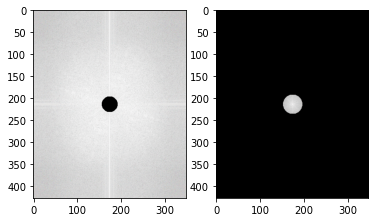

In [6]:

lowpassed = far_dft * np.repeat(lowpass_filter_cut[:, :, np.newaxis], 3, axis=2)
highpassed = near_dft * np.repeat(highpass_filter_cut[:, :, np.newaxis], 3, axis=2)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(calc_log_normalized_mag(highpassed), cmap='gray')
axs[1].imshow(calc_log_normalized_mag(lowpassed), cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
دو تصویر حاصل از مرحله قبل را ترکیب میکنیم. برای قسمت اشتراک دو تبدیل بالا، میانگین گیری میکنیم. این میانگین گیری را با ضرب فیلتری که در همه جا به جز رینگ اشتراک، مقدار یک دارد انجام میدهیم. این فیلتر در رینگ اشتراک، مقدار نیم دارد.
</p>

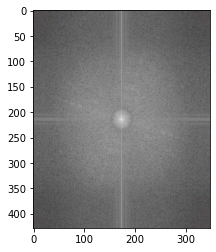

In [7]:
hybrid_dft = lowpassed + highpassed
hybrid_dft *= np.repeat((1.5 - 0.5 * (highpass_cutoff_filter + lowpass_cutoff_filter))[:, :, np.newaxis], 3, axis=2)

plt.imshow(calc_log_normalized_mag(hybrid_dft), cmap='gray')
plt.show()

<p style='direction:rtl; text-align: right'>
تصویر هیبریدی را به حوزه مکان باز میگردانیم.
</p>

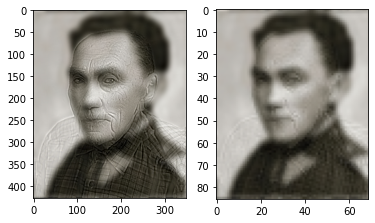

In [8]:
def calc_idft(src):
    idft_full = list()
    for i in range(3):
        idft = np.fft.ifftshift(src[:, :, i])
        idft = np.fft.ifft2(idft)
        idft_full.append(idft)
    return np.real(np.stack(idft_full, axis=2))


hybrid_near = np.clip(calc_idft(hybrid_dft), 0, 255).astype(np.uint8)
hybrid_far = hybrid_near.copy()
hybrid_far = cv.resize(hybrid_far, (0, 0), hybrid_far, 0.2, 0.2, cv.INTER_AREA)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv.cvtColor(hybrid_near, cv.COLOR_BGR2RGB))
axs[1].imshow(cv.cvtColor(hybrid_far, cv.COLOR_BGR2RGB))
plt.show()

<p style='direction:rtl; text-align: right'>
در ادامه نیز می‌توانید هرم این عکس را ببینید.
</p>

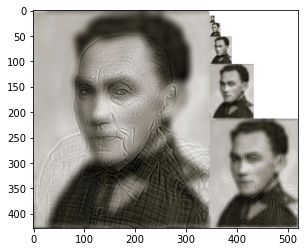

In [9]:
hybrid_pyr = np.ones((hybrid_near.shape[0], int(hybrid_near.shape[1] * 1.5) + 1, 3), dtype=np.float) * 255

ptr_i = hybrid_pyr.shape[0] - 1
ptr_j = hybrid_near.shape[1]
ctm = hybrid_near.astype(np.float)
hybrid_pyr[0:ctm.shape[0], 0:ctm.shape[1]] = ctm
for k in range(5):
    ctm = np.ascontiguousarray(ctm, dtype=np.float)
    ctm = cv.resize(ctm, (0, 0), ctm, 0.5, 0.5, interpolation=cv.INTER_LINEAR)
    ptr_i -= ctm.shape[0]
    hybrid_pyr[ptr_i:ptr_i + ctm.shape[0], ptr_j:ptr_j + ctm.shape[1]] = ctm

hybrid_pyr = np.clip(hybrid_pyr, 0, 255).astype(np.uint8)

plt.imshow(cv.cvtColor(hybrid_pyr, cv.COLOR_BGR2RGB))
plt.show()
